<a href="https://colab.research.google.com/github/Abhaya264/Colab/blob/main/siamese_glove_kag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=5a3767654305f85fca9df19d1b7c444eb7b9199ae0d66df9d86380d250d52974
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import pandas as pd
import numpy as np
import random
import warnings
import time
import datetime
import re
import string
import itertools
import pickle
import joblib
import nltk
import csv


# import nltk
# from nltk.corpus import stopwords
from nltk.corpus import stopwords, wordnet
# stop = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict

import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model
# from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

##Data

In [ ]:
from google.colab import files
data=files.upload()

Saving pharmeasy_data_2.csv to pharmeasy_data_2.csv


In [ ]:
df2= pd.read_csv('pharmeasy_data_2.csv')
display(df2.sample(5))

,user,review,star
299,Bharat Rao,Non performing good,1
263,Savitri Aghi,Started loose motion,2
1277,Saiesh Naik,Diabete increase,1
1034,Shubhangi Limaye,Product is effective but costing is high,4
898,Ramesh Kumar Choudhary,I have taken the product for 3 days only,4


In [ ]:
df2['star'][774]

5

In [ ]:
def fun(i):
  if i==5 or i==4:
    return 1
  else:
    return 0

In [ ]:
df = df2[["star", "review"]]
df['star']= df['star'].apply(fun)


In [ ]:
display(df.sample(5))

,star,review
1009,1,Good
81,1,Its taste.not liked
1355,0,Very good for health care
314,1,Good result
185,1,Its safe and.....


In [ ]:
df.shape

(1529, 2)

In [ ]:
df['star'].value_counts()

1    1235
0     294
Name: star, dtype: int64

##Data cleaning

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['clean_text'] = df['review'].apply(lambda x: remove_url(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(str(x)))
df['clean_text'] = df['clean_text'].apply(word_tokenize)
df['clean_text'] = df['clean_text'].apply(lambda x: [word.lower() for word in x])
# df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df['clean_text'] = df['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

df['clean_text'] = df['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
# df['clean_text'] = df['clean_text'].apply(
    # lambda x: [word for word in x if word not in stop])
df['clean_text'] = [' '.join(map(str, l)) for l in df['clean_text']]

In [ ]:
display(df.sample(5))

,star,review,clean_text
899,1,Karela jamun juice is helpful in controlling s...,karela jamun juice be helpful in control sugar
506,1,Good,good
567,1,Taste is not like karela,taste be not like karela
1152,1,Excellent,excellent
710,0,Not so effective unlike other co.produc,not so effective unlike other coproduc


#Contrastive Loss

##Data preparation

In [ ]:
disaster_initial = list(df[df['star'] == 1]['clean_text'])
non_disaster_initial = list(df[df['star'] == 0]['clean_text'])

# Selecting only 1000 samples for siamese model
disaster = disaster_initial[:1000]
non_disaster = non_disaster_initial[:1000]

# Creating pairs of data for siamese training => label 1 if pairs from same class otherwise 0
df2 = pd.DataFrame(columns=['text1', 'text2', 'label'])

for data in disaster:
  data1 = data
  data2 = random.choice(disaster)
  data3 = random.choice(non_disaster)

  df2.loc[len(df2)] = [data1, data2, 1]
  df2.loc[len(df2)] = [data1, data3, 0]


for data in non_disaster:
  data1 = data
  data2 = random.choice(non_disaster)
  data3 = random.choice(disaster)

  df2.loc[len(df2)] = [data1, data2, 1]
  df2.loc[len(df2)] = [data1, data3, 0]

In [ ]:
df2.shape

(2588, 3)

In [ ]:
display(df2.sample(5))

,text1,text2,label
2485,give constipation problem,this be good for health,0
1465,karelajamun juice very nice,not reduce blood sugar diabetes,0
1120,excellent,like,1
1970,very nice product,experience be too good,1
1626,satisfied,it good my fasting and pp up down i feel energ...,1


##Data Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df2[['text1', 'text2']], df2['label'], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2070, 2) (518, 2) (2070,) (518,)


In [ ]:
X_train['text'] = X_train[['text1', 'text2']].apply(lambda x: str(x[0])+" "+str(x[1]), axis=1)


##Glove Embeddings

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['text1'] = X_train['text1'].astype(str)
X_train['text2'] = X_train['text2'].astype(str)
X_val['text1'] = X_val['text1'].astype(str)
X_val['text2'] = X_val['text2'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['text1'].values)
train_q2_seq = t.texts_to_sequences(X_train['text2'].values)
val_q1_seq = t.texts_to_sequences(X_val['text1'].values)
val_q2_seq = t.texts_to_sequences(X_val['text2'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [ ]:
print(embedding_matrix.shape)

(1169, 300)


##Siamese model

In [ ]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [ ]:
def build_network():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1,
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix],
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3)))
                  # kernel_initializer='he_uniform'))

  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3)))
                  # kernel_initializer='he_uniform'))

  #Force the encoding to live on the d-dimentional hypershpere
  network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network

In [ ]:
input_1 = Input(shape=(train_q1_seq.shape[1],))
input_2 = Input(shape=(train_q2_seq.shape[1],))

network = build_network()

encoded_input_1 = network(input_1)
encoded_input_2 = network(input_2)

distance = Lambda(euclidean_distance)([encoded_input_1, encoded_input_2])

# Connect the inputs with the outputs
model = Model([input_1, input_2], distance)

model.compile(loss=contrastive_loss,metrics=['accuracy'], optimizer=Adam(0.001))

In [ ]:
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [ ]:
model.fit([train_q1_seq,train_q2_seq],y_train.reshape(-1,1), epochs = 5,
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq],y_val.reshape(-1,1)))

Epoch 1/5
33/33 [==============================] - 25s 665ms/step - loss: 0.4741 - accuracy: 0.4899 - val_loss: 0.3916 - val_accuracy: 0.4807
Epoch 2/5
33/33 [==============================] - 22s 650ms/step - loss: 0.3542 - accuracy: 0.4541 - val_loss: 0.3253 - val_accuracy: 0.4208
Epoch 3/5
33/33 [==============================] - 24s 737ms/step - loss: 0.2878 - accuracy: 0.3512 - val_loss: 0.2734 - val_accuracy: 0.3224
Epoch 4/5
33/33 [==============================] - 25s 725ms/step - loss: 0.2332 - accuracy: 0.2604 - val_loss: 0.2588 - val_accuracy: 0.2896
Epoch 5/5
33/33 [==============================] - 23s 689ms/step - loss: 0.1992 - accuracy: 0.2034 - val_loss: 0.2273 - val_accuracy: 0.2239


#Triplet Loss

##Data Preparation

In [ ]:
disaster_initial = list(df[df['star'] == 1]['clean_text'])
non_disaster_initial = list(df[df['star'] == 0]['clean_text'])

# Taking 1000 samples from the entire data
disaster = disaster_initial[:1000]
non_disaster = non_disaster_initial[:1000]

# Creating pairs of data for siamese training => labels for identity loss and class for disaster or non disaster
df2 = pd.DataFrame(columns=['Anchor', 'Positive', 'Negative', 'label', 'class'])

for data in disaster:
  a = data
  p = random.choice(disaster)
  n = random.choice(non_disaster)

  df2.loc[len(df2)] = [a, p, n, 1, 1]


for data in non_disaster:
  a = data
  p = random.choice(non_disaster)
  n = random.choice(disaster)

  df2.loc[len(df2)] = [a, p, n, 1, 0]


In [ ]:
df2.shape

(1294, 5)

In [ ]:
display(df2.sample(5))

,Anchor,Positive,Negative,label,class
1160,leave a very bad taste in the mouth,both bottle mixing not proper,quick service,1,0
798,very useful for diabetic patient,all good need two more bottle same and lantus ...,quality be not good this time than before use ...,1,1
417,super,we good effect,i feel batter,1,1
610,serum,it be very effective product for sugar pationt...,not helpful,1,1
393,like,reduction in sugar level and lethargy,no improvement in sugar level,1,1


##Data split

In [ ]:
X, X_test, y, y_test = train_test_split(df2[['Anchor', 'Positive', 'Negative']], df2[['label', 'class']], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X[['Anchor', 'Positive', 'Negative']], y[['label', 'class']], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(828, 3) (207, 3) (259, 3) (828, 2) (207, 2) (259, 2)


In [ ]:
X_train['text'] = X_train[['Anchor', 'Positive', 'Negative']].apply(lambda x: str(x[0])+" "+str(x[1])+" "+str(x[2]), axis=1)

##Glove Embeddings

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['Anchor'] = X_train['Anchor'].astype(str)
X_train['Positive'] = X_train['Positive'].astype(str)
X_train['Negative'] = X_train['Negative'].astype(str)
X_val['Anchor'] = X_val['Anchor'].astype(str)
X_val['Positive'] = X_val['Positive'].astype(str)
X_val['Negative'] = X_val['Negative'].astype(str)
X_test['Anchor'] = X_test['Anchor'].astype(str)
X_test['Positive'] = X_test['Positive'].astype(str)
X_test['Negative'] = X_test['Negative'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['Anchor'].values)
train_q2_seq = t.texts_to_sequences(X_train['Positive'].values)
train_q3_seq = t.texts_to_sequences(X_train['Negative'].values)
val_q1_seq = t.texts_to_sequences(X_val['Anchor'].values)
val_q2_seq = t.texts_to_sequences(X_val['Positive'].values)
val_q3_seq = t.texts_to_sequences(X_val['Negative'].values)
test_q1_seq = t.texts_to_sequences(X_test['Anchor'].values)
test_q2_seq = t.texts_to_sequences(X_test['Positive'].values)
test_q3_seq = t.texts_to_sequences(X_test['Negative'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
train_q3_seq = pad_sequences(train_q3_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
val_q3_seq = pad_sequences(val_q3_seq, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1_seq, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=max_len, padding='post')
test_q3_seq = pad_sequences(test_q3_seq, maxlen=max_len, padding='post')

In [ ]:
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [ ]:
print(embedding_matrix.shape)

(1094, 300)


##Siamese Model

In [ ]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [ ]:
def embedding_model():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1,
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix],
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))

  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))

  #Force the encoding to live on the d-dimentional hypershpere
  # network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network


def build_network(base_model):

  input_1 = Input(shape=(train_q1_seq.shape[1],))
  input_2 = Input(shape=(train_q2_seq.shape[1],))
  input_3 = Input(shape=(train_q3_seq.shape[1],))

  A = base_model(input_1)
  P = base_model(input_2)
  N = base_model(input_3)

  loss = Lambda(triplet_loss)([A, P, N])
  model = Model(inputs = [input_1, input_2, input_3], outputs = loss)
  model.compile(loss = identity_loss, optimizer = Adam(0.001))
  return model

In [ ]:
base_model = embedding_model()
model = build_network(base_model)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 input_23 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 input_24 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 2)                    2060426   ['input_22[0][0]',            
                                                                     'input_23[0][0]',      

In [ ]:
y_train_label = np.asarray(y_train['label']).astype('float32')
y_val_label = np.asarray(y_val['label']).astype('float32')
y_test_label = np.asarray(y_test['label']).astype('float32')

y_train_class = np.asarray(y_train['class']).astype('float32')
y_val_class = np.asarray(y_val['class']).astype('float32')
y_test_class = np.asarray(y_test['class']).astype('float32')

In [ ]:
history = model.fit([train_q1_seq,train_q2_seq, train_q3_seq],y_train_label.reshape(-1,1), epochs = 5,
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq, val_q3_seq],y_val_label.reshape(-1,1)))

Epoch 1/5
13/13 [==============================] - 17s 955ms/step - loss: 0.3498 - val_loss: 0.2522
Epoch 2/5
13/13 [==============================] - 13s 982ms/step - loss: 0.2281 - val_loss: 0.2062
Epoch 3/5
13/13 [==============================] - 13s 1s/step - loss: 0.1863 - val_loss: 0.1857
Epoch 4/5
13/13 [==============================] - 13s 1s/step - loss: 0.1370 - val_loss: 0.1643
Epoch 5/5
13/13 [==============================] - 18s 1s/step - loss: 0.1101 - val_loss: 0.1752


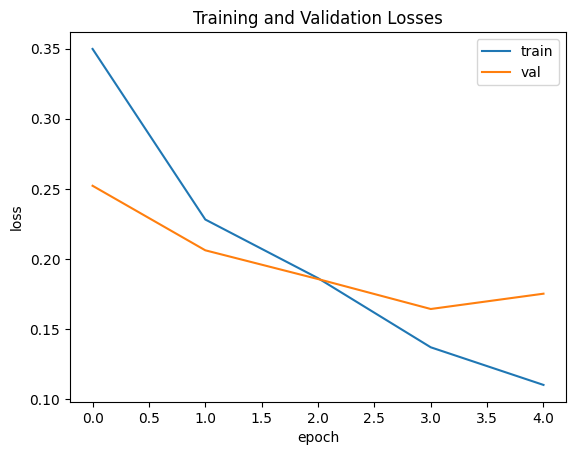

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Evaluation

In [ ]:
X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)

# TSNE - dimensionality reduction for data visualization
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_eval)

9/9 [==============================] - 3s 348ms/step


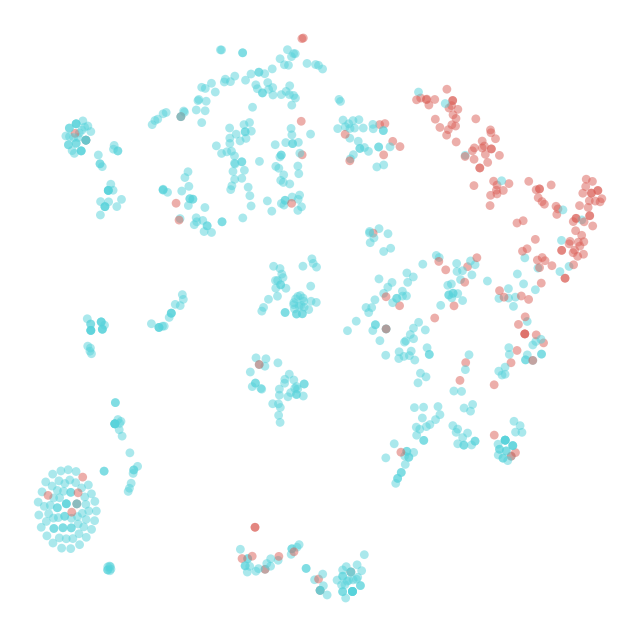

In [ ]:
def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int_)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

scatter(train_tsne_embeds, y_train_class)

In [ ]:
from keras.utils import to_categorical

In [ ]:
classifier_input = Input(shape=(2,))
classifier_output = Dense(2, activation='softmax')(classifier_input)
classifier_model = Model(classifier_input, classifier_output)

# onehot encoding vectors to 2 classes
Y_train_onehot = to_categorical(y_train_class, 2)
Y_test_onehot = to_categorical(y_test_class, 2)

classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier_model.fit(X_train_eval,Y_train_onehot, validation_data=(X_test_eval, Y_test_onehot),epochs=5)

Epoch 1/5
26/26 [==============================] - 2s 26ms/step - loss: 0.6434 - accuracy: 0.7681 - val_loss: 0.6488 - val_accuracy: 0.6911
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6268 - accuracy: 0.8080 - val_loss: 0.6359 - val_accuracy: 0.7413
Epoch 3/5
26/26 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.8333 - val_loss: 0.6234 - val_accuracy: 0.7838
Epoch 4/5
26/26 [==============================] - 0s 3ms/step - loss: 0.5973 - accuracy: 0.8490 - val_loss: 0.6119 - val_accuracy: 0.8494
Epoch 5/5
26/26 [==============================] - 0s 3ms/step - loss: 0.5840 - accuracy: 0.8671 - val_loss: 0.6015 - val_accuracy: 0.8533


In [ ]:
X_train_eval.shape

(828, 2)

In [ ]:
Y_train_onehot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

#EXTRA BIT

In [ ]:
X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_9" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 200) dtype=int32>]
